In [20]:
# python 3.11
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
from collections import defaultdict
import math

# STEP 1:

The dataset was loaded, and an initial examination of its first few rows was performed to better understand its structure and contents.

In [21]:
df = pd.read_csv("amazon_reviews.csv")
df.head()

,Title,Content,Star
0,Didn't work,No change in nails at all.,1.0
1,Worst nail product I have ever used.,Garbage! Do not waste your $$$. My nails were ...,1.0
2,Just didn't work,Nails are still brittle,1.0
3,Scum,Didn’t do any improvement at all.,1.0
4,Okay for cuticles,"Helped cuticles, didn't do much for my nails. ...",1.0


A count plot was created to visualize the distribution of star ratings.
After displaying the plot, it was observed that the number of reviews was equal for each star rating.x

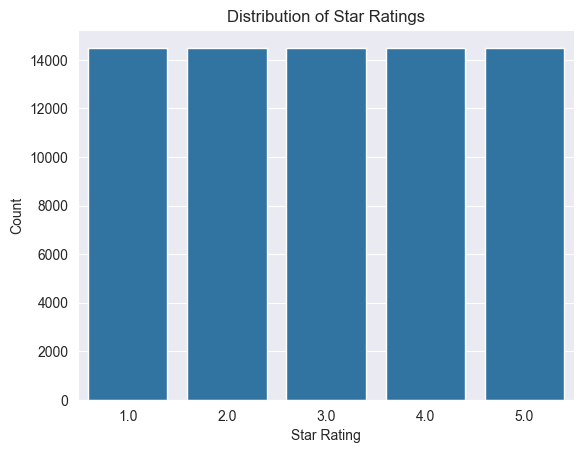

In [22]:
sns.countplot(x='Star', data=df)
plt.title("Distribution of Star Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.show()


The lengths of the titles and contents were calculated by counting the number of words in each.
The average lengths for both titles and contents were then computed to better understand the typical size of the reviews.
Afterward, a histogram was created to visualize the distribution of content lengths.
From the histogram, it was observed that most reviews contained a relatively small number of words, with only a few reviews being significantly longer.

In [23]:
df['title_length'] = df['Title'].astype(str).apply(lambda x: len(x.split()))
df['content_length'] = df['Content'].astype(str).apply(lambda x: len(x.split()))

min_title_length = df['title_length'].min()
max_title_length = df['title_length'].max()

print("Minimum Title Length:", min_title_length)
print("Maximum Content Length:", max_title_length)

print("Average Title Length:", df['title_length'].mean())
print("Average Content Length:", df['content_length'].mean())


Minimum Title Length: 1
Maximum Content Length: 25
Average Title Length: 4.170965517241379
Average Content Length: 36.46804137931034


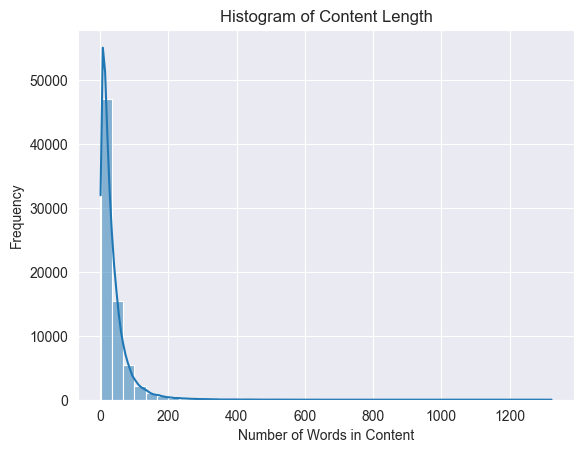

In [24]:
sns.histplot(df['content_length'], bins=40, kde=True)
plt.title("Histogram of Content Length")
plt.xlabel("Number of Words in Content")
plt.ylabel("Frequency")
plt.show()


The text from all reviews was combined into a single string to create a unified body of text.
A word cloud was then generated to visually represent the most frequently used words in the review content.
After displaying the word cloud, it was observed that words such as "use," "one," and "product" appeared most prominently, indicating their frequent usage among the reviews.

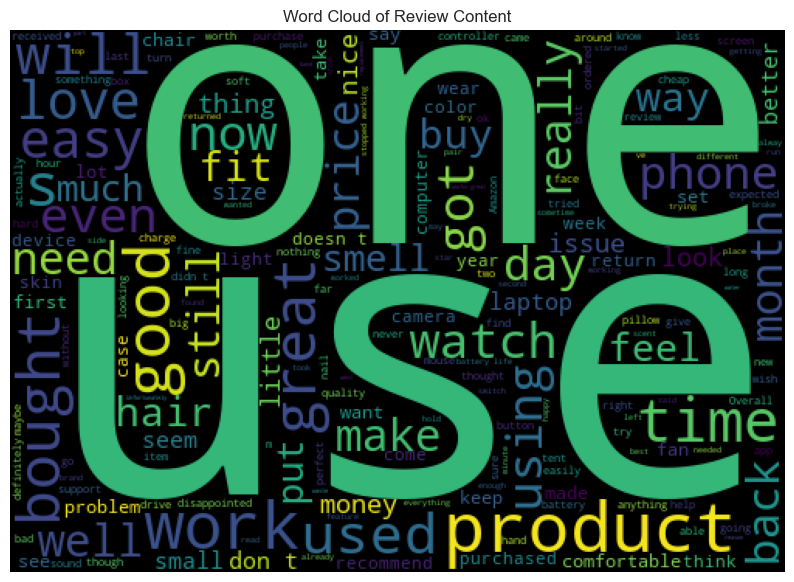

In [25]:
text = " ".join(review for review in df['Content'].astype(str))
wordcloud = WordCloud(width=500, height=350).generate(text)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='hermite')
plt.axis('off')
plt.title("Word Cloud of Review Content")
plt.show()


The text in the title and content fields was cleaned by converting all characters to lowercase and removing unwanted symbols, while preserving basic punctuation marks for future analysis.
After the cleaning process, the title and content of each review were combined into a single text field to facilitate further processing.

In [26]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s.,!?]', '', text)  # keep . , ! ? for n-gram purposes
    return text

df['Title'] = df['Title'].astype(str).apply(clean_text)
df['Content'] = df['Content'].astype(str).apply(clean_text)
df['Combined'] = df['Title'] + " " + df['Content']


A tokenization function was defined to split the text into individual words or into sequences of two or three consecutive words, depending on the specified value of n. A token is a single unit of text, such as a word or phrase, and tokenization is the process of breaking text into these smaller meaningful units. This allowed the text to be prepared for further analysis using unigrams (single words), bigrams (pairs of consecutive words), or trigrams (triplets of consecutive words).

In [27]:
def tokenize(text, n=1):
    words = text.split()
    if n == 1:
        return words
    elif n == 2:
        return [f"{words[i]} {words[i+1]}" for i in range(len(words)-1)]
    elif n == 3:
        return [f"{words[i]} {words[i+1]} {words[i+2]}" for i in range(len(words)-2)]


A sample text from the combined reviews was selected and tokenized into unigrams, bigrams, and trigrams.
Through this process, the structure and behavior of the tokenization function were verified.

In [28]:
sample = df['Combined'].iloc[0]
print("Unigrams:", tokenize(sample, 1))
print("Bigrams:", tokenize(sample, 2))
print("Trigrams:", tokenize(sample, 3))


Unigrams: ['didnt', 'work', 'no', 'change', 'in', 'nails', 'at', 'all.']
Bigrams: ['didnt work', 'work no', 'no change', 'change in', 'in nails', 'nails at', 'at all.']
Trigrams: ['didnt work no', 'work no change', 'no change in', 'change in nails', 'in nails at', 'nails at all.']


A stopword is defined as a commonly occurring word—such as "the," "is," "in," or "and"—that is typically considered to carry limited semantic value in text analysis. These words are often removed during preprocessing so that attention can be focused on more informative terms.

In this context, a predefined list of stopwords was selected (FOUND ON GITHUB https://gist.github.com/sebleier/554280). It included personal pronouns (e.g., "I", "you", "they"), auxiliary verbs (e.g., "is", "was", "have"), articles and conjunctions (e.g., "the", "a", "and", "but"), and prepositions (e.g., "in", "on", "with"). These words were chosen because they are frequently used across various texts but generally do not contribute meaningful information relevant to analytical tasks.

However, words such as "not" and "nor" were intentionally not included in the stopword list, as they convey negation, which can significantly affect the sentiment or meaning of a sentence. Retaining such words was considered important for preserving the contextual polarity of the text.

To ensure that only significant tokens were retained, the selected stopwords were removed from unigrams, bigrams, and trigrams. This step was taken to improve the clarity and effectiveness of subsequent analysis. To evaluate the effectiveness of the stopword removal process, examples were displayed both before and after the filtering was applied.

In [29]:
stopwords = {"i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "now"}


def remove_stopwords(tokens):
    return [token for token in tokens if token not in stopwords]

df['clean_tokens'] = df['Combined'].apply(lambda x: remove_stopwords(tokenize(x, 1)))



def remove_stopwords_from_bigrams(bigrams):
    return [bigram for bigram in bigrams
            if all(word not in stopwords for word in bigram.split())]

df['clean_bigrams'] = df['Combined'].apply(lambda x: remove_stopwords_from_bigrams(tokenize(x, 2)))



def remove_stopwords_from_trigrams(trigrams):
    return [trigram for trigram in trigrams
            if all(word not in stopwords for word in trigram.split())]

df['clean_trigrams'] = df['Combined'].apply(lambda x: remove_stopwords_from_trigrams(tokenize(x, 3)))


A function was implemented to calculate the frequency of tokens within a collection of texts.
Depending on the specified n-gram level, unigrams, bigrams etc.
Stopwords were removed to focus on more meaningful terms, and the frequency of each token was counted and stored.
This process enabled the identification of the most commonly occurring terms or phrases in the dataset. Stopwords will be explained in next code block.

In [30]:
def get_token_frequencies(texts, n_gram):
    freq = defaultdict(int)

    for text in texts:
        if n_gram == 1:
            tokens = remove_stopwords(tokenize(text, 1))
        elif n_gram == 2:
            tokens = remove_stopwords_from_bigrams(tokenize(text, 2))
        elif n_gram == 3:
            tokens = remove_stopwords_from_bigrams(tokenize(text, 3))

        for token in tokens:
            freq[token] += 1

    return freq


print("Unigram Before:", tokenize(df['Combined'].iloc[0], 1))
print("Unigram After :", remove_stopwords(tokenize(df['Combined'].iloc[0], 1)))


print("Bigram Before:", tokenize(df['Combined'].iloc[0], 2))
print("Bigram After :", remove_stopwords_from_bigrams(tokenize(df['Combined'].iloc[0], 2)))


print("Trigram Before:", tokenize(df['Combined'].iloc[0], 3))
print("Trigram After :", remove_stopwords_from_trigrams(tokenize(df['Combined'].iloc[0], 3)))

Unigram Before: ['didnt', 'work', 'no', 'change', 'in', 'nails', 'at', 'all.']
Unigram After : ['didnt', 'work', 'no', 'change', 'nails', 'all.']
Bigram Before: ['didnt work', 'work no', 'no change', 'change in', 'in nails', 'nails at', 'at all.']
Bigram After : ['didnt work', 'work no', 'no change']
Trigram Before: ['didnt work no', 'work no change', 'no change in', 'change in nails', 'in nails at', 'nails at all.']
Trigram After : ['didnt work no', 'work no change']


A sentiment label was assigned to each review based on its star rating: reviews with 1 or 2 stars were labeled as negative, and those with 4 or 5 stars as positive. Reviews with a 3-star rating were considered neutral and were excluded to maintain a clear separation between sentiment categories. As a result, rows without a sentiment label were removed from the dataset.

To assess the impact of how 3-star reviews are handled, three different labeling strategies were compared: treating 3-star reviews as neutral and excluding them, treating them as positive, and treating them as negative. F1 scores were then calculated for each tokenization level (unigram, bigram, trigram) under these strategies.

Results and Inferences:
1. When 3-star reviews were treated as neutral (excluded):
Unigram F1 score: 0.8802

Bigram F1 score: 0.8161

Trigram F1 score: 0.5850

This approach yielded the highest F1 scores overall, especially for unigrams and bigrams. By removing the inherently ambiguous 3-star reviews, the model was trained on more polarized and clearly defined examples of sentiment, allowing for better differentiation between positive and negative classes. This clearer signal likely improved classification performance.

2. When 3-star reviews were treated as positive:
Unigram F1 score: 0.7732

Bigram F1 score: 0.7199

Trigram F1 score: 0.5673

Treating 3-star reviews as positive resulted in a noticeable drop in F1 scores across all n-gram levels. Since 3-star reviews often contain mixed or neutral language, grouping them with genuinely positive reviews may have introduced noise, reducing the model's ability to learn distinct positive features.

3. When 3-star reviews were treated as negative:
Unigram F1 score: 0.8331

Bigram F1 score: 0.7756

Trigram F1 score: 0.5759

This strategy performed better than labeling 3-star reviews as positive but still worse than excluding them. It suggests that 3-star reviews may be slightly more aligned in language or tone with negative reviews than with positive ones, but they still add ambiguity and lower the model's precision.

Conclusion:
The highest classification performance was achieved when 3-star reviews were excluded. This indicates that their inclusion—regardless of whether they were labeled as positive or negative—introduces ambiguity that weakens the sentiment signal. Therefore, for binary sentiment analysis tasks aiming for clear positive/negative separation, it is advisable to remove neutral reviews from the training data.

In [31]:
def label_sentiment(star):
    if star in [1, 2]:
        return 0  # Negative
    elif star in [4, 5]:
        return 1  # Positive
    else:
        return None  # Neutral or ignored

df['Label'] = df['Star'].apply(label_sentiment)
df = df.dropna(subset=['Label'])  # Drop rows with 3-star or missing labels


The title and content fields were re-concatenated and stored in the combined text column to ensure that the most up-to-date, cleaned versions of both fields were reflected in the analysis.

In [32]:
df.loc[:, 'Combined'] = df['Title'].astype(str) + " " + df['Content'].astype(str)

The dataset was divided into training and testing subsets using an 80-20 split.

In [33]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['Label']
)

Token frequencies were calculated from the training dataset using both unigrams and bigrams.
A minimum frequency threshold was applied to filter out infrequent tokens.
Tokens that appeared at least twice were retained and stored in a set to form the vocabulary of known tokens for further processing.

In [34]:
# Count token frequencies on training data
min_freq = 2  # You can adjust if needed
token_freq = get_token_frequencies(train_df['Combined'], n_gram=1)

# Build set of known tokens
known_tokens = set(token for token, count in token_freq.items() if count >= min_freq)


Separate frequency dictionaries were constructed for unigrams, bigrams, and trigrams using the training data.
Stopwords were removed from unigrams, bigrams and trigrams to focus on meaningful terms.
Each token's frequency was counted and stored in a dictionary.
The most common tokens in each n-gram category were then displayed to observe the dominant patterns in the text.

In [35]:
# Build unigram dictionary
unigram_freq = defaultdict(int)
for text in train_df['Combined']:
    tokens = remove_stopwords(tokenize(text, 1))  # tokenized + cleaned
    for token in tokens:
        unigram_freq[token] += 1
unigram_dict = dict(unigram_freq)

# Build bigram dictionary
bigram_freq = defaultdict(int)
for text in train_df['Combined']:
    bigrams = remove_stopwords_from_bigrams(tokenize(text, 2))
    for bigram in bigrams:
        bigram_freq[bigram] += 1
bigram_dict = dict(bigram_freq)

# Build trigram dictionary
trigram_freq = defaultdict(int)
for text in train_df['Combined']:
    trigrams = remove_stopwords_from_trigrams(tokenize(text, 3))
    for trigram in trigrams:
        trigram_freq[trigram] += 1
trigram_dict = dict(trigram_freq)



print("Top 10 Unigrams:")
print(Counter(unigram_dict).most_common(10))

print("\nTop 10 Bigrams:")
print(Counter(bigram_dict).most_common(10))

print("\nTop 10 Trigrams:")
print(Counter(trigram_dict).most_common(10))


Top 10 Unigrams:
[('not', 22320), ('good', 10510), ('great', 10287), ('like', 8046), ('one', 6585), ('use', 6070), ('would', 5694), ('product', 5542), ('dont', 5292), ('no', 5234)]

Top 10 Bigrams:
[('would not', 783), ('battery life', 721), ('not sure', 673), ('works great', 634), ('stopped working', 633), ('im not', 600), ('great product', 599), ('not work', 579), ('not worth', 574), ('doesnt work', 517)]

Top 10 Trigrams:
[('would not recommend', 201), ('im not sure', 185), ('would not buy', 102), ('not worth it.', 61), ('could not get', 59), ('would not recommend.', 58), ('doesnt last long', 50), ('not buy again.', 48), ('would highly recommend', 42), ('fitbit charge 4', 40)]


A custom NaiveBayesClassifier was developed to perform sentiment classification based on various n-gram representations. The model was designed to support unigram, bigram, trigram, and combined n-gram configurations. During training, tokens were extracted from the input texts, filtered using a list of known tokens (when provided), and their frequencies were updated per class using weighted counts. The weights were adjusted based on the associated star ratings to reflect varying confidence levels in sentiment (e.g., 1-star and 5-star reviews were given higher weights).

During prediction, separate token sets were created for the title and content. The probabilities of each class were computed using log-likelihoods, with weighted contributions from the title and content tokens. Laplace smoothing was applied to handle unseen tokens. The class with the highest log-probability was selected as the final prediction.

The classifier was trained separately for unigram, bigram, trigram, and combined n-gram modes using the training set. Each model was then used to predict the sentiment of reviews in the test set, and the predictions were stored in new columns for evaluation.

In [36]:
class NaiveBayesClassifier:
    def __init__(self, n_gram=1):
        self.n_gram = n_gram
        self.class_token_counts = defaultdict(lambda: defaultdict(int))
        self.class_total_tokens = defaultdict(int)
        self.class_doc_counts = defaultdict(int)
        self.vocabulary = set()
        self.num_docs = 0
        self.known_tokens = None  # Will set it externally before training



    def train(self, texts, labels, stars):
        for text, label, star in zip(texts, labels, stars):
            self.class_doc_counts[label] += 1
            self.num_docs += 1

            # Determine weighting factor
            weight = 1.0
            if label == 0:  # Negative
                weight = 1.0 if star == 1 else 0.5
            elif label == 1:  # Positive
                weight = 1.0 if star == 5 else 0.5

            # Tokenization
            if self.n_gram == 1:
                tokens = remove_stopwords(tokenize(text, 1))
            elif self.n_gram == 2:
                tokens = remove_stopwords_from_bigrams(tokenize(text, 2))
            elif self.n_gram == 3:
                tokens = remove_stopwords_from_trigrams(tokenize(text, 3))
            else:
                tokens = tokenize(text, self.n_gram)

            for token in tokens:
                 if self.known_tokens is not None:
                        token = token if token in self.known_tokens else "<UNK>"
                 self.vocabulary.add(token)
                 self.class_token_counts[label][token] += weight
                 self.class_total_tokens[label] += weight

    def predict_with_weights(self, title, content, title_weight=0.3, content_weight=0.7):
        if self.n_gram == 1:
            title_tokens = remove_stopwords(tokenize(title, 1))
            content_tokens = remove_stopwords(tokenize(content, 1))
        elif self.n_gram == 2:
            title_tokens = remove_stopwords_from_bigrams(tokenize(title, 2))
            content_tokens = remove_stopwords_from_bigrams(tokenize(content, 2))
        elif self.n_gram == 3:
            title_tokens = remove_stopwords_from_trigrams(tokenize(title, 3))
            content_tokens = remove_stopwords_from_trigrams(tokenize(content, 3))
        else:
            title_tokens = tokenize(title, self.n_gram)
            content_tokens = tokenize(content, self.n_gram)

        class_scores = {}

        for c in self.class_doc_counts:
            # Prior: log P(C)
            log_prob = math.log(self.class_doc_counts[c] / self.num_docs)
            total_tokens = self.class_total_tokens[c]
            vocab_size = len(self.vocabulary)

            # Weighted title contribution
            for token in title_tokens:
                token = token if token in self.vocabulary else "<UNK>"
                token_count = self.class_token_counts[c].get(token, 0)
                prob = (token_count + 1) / (total_tokens + vocab_size)
                log_prob += title_weight * math.log(prob)

            # Weighted content contribution
            for token in content_tokens:
                token = token if token in self.vocabulary else "<UNK>"
                token_count = self.class_token_counts[c].get(token, 0)
                prob = (token_count + 1) / (total_tokens + vocab_size)
                log_prob += content_weight * math.log(prob)

            class_scores[c] = log_prob

        return max(class_scores, key=class_scores.get)


#Training
nb_unigram = NaiveBayesClassifier(n_gram=1)
nb_bigram = NaiveBayesClassifier(n_gram=2)
nb_trigram = NaiveBayesClassifier(n_gram=3)

nb_unigram.train(train_df['Combined'], train_df['Label'], train_df['Star'])
nb_bigram.train(train_df['Combined'], train_df['Label'], train_df['Star'])
nb_trigram.train(train_df['Combined'], train_df['Label'], train_df['Star'])


# UNIGRAM predictions
test_df['pred_uni'] = test_df.apply(
    lambda row: nb_unigram.predict_with_weights(row['Title'], row['Content'], 0.6, 0.4),
    axis=1
)

# BIGRAM predictions
test_df['pred_bi'] = test_df.apply(
    lambda row: nb_bigram.predict_with_weights(row['Title'], row['Content'], 0.6, 0.4),
    axis=1
)

test_df['pred_tri'] = test_df.apply(
    lambda row: nb_trigram.predict_with_weights(row['Title'], row['Content'], 0.6, 0.4),
    axis=1
)


Predictions generated by each Naive Bayes model were evaluated using a custom compute_metrics function. For each prediction, true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN) were counted. Based on these counts, the following metrics were computed:

Accuracy: The ratio of correctly predicted instances over all predictions.

Precision: The ratio of correctly predicted positive instances over all predicted positives.

Recall: The ratio of correctly predicted positive instances over all actual positives.

F1-score: The harmonic mean of precision and recall.

Metrics were calculated for each model individually and then assembled into a comparison table. This table was formatted to display the key performance indicators for each model in a concise and interpretable format.

In [37]:
def compute_metrics(y_true, y_pred):
    TP = FP = TN = FN = 0

    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            TP += 1
        elif true == 0 and pred == 1:
            FP += 1
        elif true == 0 and pred == 0:
            TN += 1
        elif true == 1 and pred == 0:
            FN += 1

    accuracy = (TP + TN) / (TP + TN + FP + FN) if TP + TN + FP + FN > 0 else 0
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 / (1/precision + 1/recall) if precision + recall > 0 else 0

    return {
        "TP": TP, "TN": TN, "FP": FP, "FN": FN,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }



# Compute metrics separately for each model
metrics_uni = compute_metrics(test_df['Label'].tolist(), test_df['pred_uni'].tolist())
metrics_bi = compute_metrics(test_df['Label'].tolist(), test_df['pred_bi'].tolist())
metrics_tri = compute_metrics(test_df['Label'].tolist(), test_df['pred_tri'].tolist())

# Create a clean comparison table
results_df = pd.DataFrame([
    {"Model": "Unigram", **metrics_uni},
    {"Model": "Bigram", **metrics_bi},
    {"Model": "Trigram", **metrics_tri}
])

# Show comparison
results_df = results_df[["Model", "accuracy", "precision", "recall", "f1_score"]]
results_df





,Model,accuracy,precision,recall,f1_score
0,Unigram,0.828276,0.810401,0.857069,0.833082
1,Bigram,0.770431,0.758445,0.793621,0.775634
2,Trigram,0.534483,0.528843,0.632241,0.575938


The predictions generated by each Naive Bayes model were assessed using a custom compute_metrics function. This function was used to calculate key performance metrics based on the counts of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN). The following metrics were then derived:

Accuracy: The proportion of correctly predicted instances out of all predictions.

Precision: The ratio of correctly predicted positive instances to the total predicted positives.

Recall: The ratio of correctly predicted positive instances to the total actual positives.

F1-score: The harmonic mean of precision and recall, providing a balance between the two metrics.

The metrics were computed individually for each Naive Bayes model (unigram, bigram, trigram, and combined) and were organized into a comparison table. This table was structured to present each model's key performance indicators in a clear and easy-to-understand format. The comparison of the models allowed for an evaluation of their relative strengths and weaknesses in terms of prediction accuracy and reliability.

In [38]:
def manual_confusion_matrix(y_true, y_pred):
    TP = FP = TN = FN = 0

    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            TP += 1
        elif true == 0 and pred == 1:
            FP += 1
        elif true == 0 and pred == 0:
            TN += 1
        elif true == 1 and pred == 0:
            FN += 1

    return [[TN, FP],
            [FN, TP]]


# Unigram Confusion Matrix
cm_uni = manual_confusion_matrix(test_df['Label'].tolist(), test_df['pred_uni'].tolist())
print(" Unigram Confusion Matrix:")
print("[TN FP]")
print(cm_uni[0])
print("[FN TP]")
print(cm_uni[1])


# Bigram Confusion Matrix
cm_bi = manual_confusion_matrix(test_df['Label'].tolist(), test_df['pred_bi'].tolist())
print("\n Bigram Confusion Matrix:")
print("[TN FP]")
print(cm_bi[0])
print("[FN TP]")
print(cm_bi[1])


# Bigram Confusion Matrix
cm_tri = manual_confusion_matrix(test_df['Label'].tolist(), test_df['pred_tri'].tolist())
print("\n Trigram Confusion Matrix:")
print("[TN FP]")
print(cm_tri[0])
print("[FN TP]")
print(cm_tri[1])

 Unigram Confusion Matrix:
[TN FP]
[4637, 1163]
[FN TP]
[829, 4971]

 Bigram Confusion Matrix:
[TN FP]
[4334, 1466]
[FN TP]
[1197, 4603]

 Trigram Confusion Matrix:
[TN FP]
[2533, 3267]
[FN TP]
[2133, 3667]
